In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [50]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='SHOP'
stock_parameter ='Daily gain'
epoch_number=50
epoch_number_forecast=50

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)
stock['Daily gain']=stock['Adj Close'].pct_change(1)
stock=stock.dropna(axis=0)
stock

,High,Low,Open,Close,Volume,Adj Close,Daily gain
Date,,,,,,,
2019-05-07,266.500000,254.699997,264.359985,258.690002,2589400,258.690002,-0.025723
2019-05-08,264.619995,257.510010,258.700012,261.510010,1847500,261.510010,0.010901
2019-05-09,261.359985,254.119995,258.880005,260.619995,1831000,260.619995,-0.003403
2019-05-10,262.989990,252.639999,260.429993,258.829987,1674900,258.829987,-0.006868
2019-05-13,253.063004,245.619995,247.910004,250.789993,1938800,250.789993,-0.031063
...,...,...,...,...,...,...,...
2020-04-28,639.760010,610.099976,634.000000,633.650024,3685700,633.650024,0.008066
2020-04-29,645.549988,621.130005,637.000000,639.989990,2403900,639.989990,0.010005
2020-04-30,645.979980,623.000000,625.000000,632.289978,2446000,632.289978,-0.012031


In [51]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [52]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [53]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [55]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [56]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten

In [58]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))


model.add(Dense(1, input_shape=(length, n_features)))
model.add(LSTM(64))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='SGD', loss='mse')

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [60]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [61]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 212 steps, validate for 1 steps
Epoch 1/50
212/212 [==============================] - 5s 22ms/step - loss: 0.0446 - val_loss: 0.0061
Epoch 2/50
212/212 [==============================] - 2s 9ms/step - loss: 0.0407 - val_loss: 0.0433
Epoch 3/50
212/212 [==============================] - 2s 8ms/step - loss: 0.0367 - val_loss: 0.0073
Epoch 4/50
212/212 [==============================] - 2s 8ms/step - loss: 0.0321 - val_loss: 0.0092
Epoch 5/50
212/212 [==============================] - 2s 9ms/step - loss: 0.0259 - val_loss: 0.0050
Epoch 6/50
212/212 [==============================] - 2s 8ms/step - loss: 0.0276 - val_loss: 0.0126
Epoch 7/50
212/212 [==============================] - 2s 8ms/step - loss: 0.0248 - val_loss: 0.0094
Epoch 8/50
212/212 [==============================] - 2s 8ms/step - loss: 0.0191 - val_loss: 0.0203
Epoch 9/50
212/212 [==============================] - 2s 9ms/step - loss: 0.0233 - val_loss: 0.0067
Epoch 1

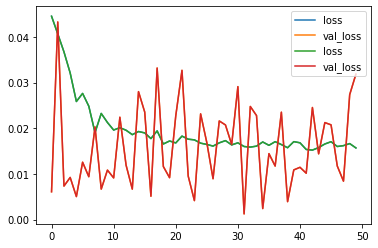

In [62]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
losses.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [63]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [64]:
true_predictions =scaler.inverse_transform(test_predictions)


In [65]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

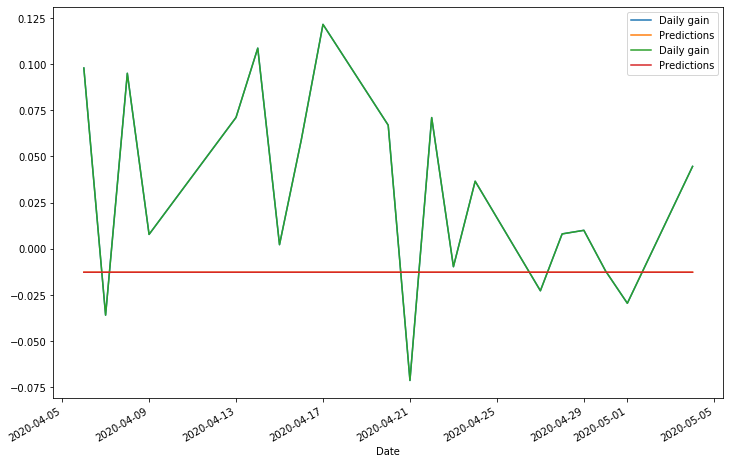

In [66]:
ax=predictions.plot(figsize=(12,8))
predictions.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'_predictions_chart.png')

In [67]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

# Forecasting

In [68]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())
# scaled_full_data

In [69]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)


In [70]:
forecast_model= Sequential()
forecast_model.add(Dense(1, input_shape=(length, n_features)))
forecast_model.add(LSTM(64))
forecast_model.add(Flatten())
forecast_model.add(Dense(512, activation='sigmoid'))
forecast_model.add(Dropout(0.4))
forecast_model.add(Dense(32, activation='sigmoid'))
forecast_model.add(Dense(1))
forecast_model.compile(optimizer='SGD', loss='mse')
forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 232 steps
Epoch 1/50
232/232 [==============================] - 5s 20ms/step - loss: 0.0564
Epoch 2/50
232/232 [==============================] - 2s 9ms/step - loss: 0.0375
Epoch 3/50
232/232 [==============================] - 2s 9ms/step - loss: 0.0314
Epoch 4/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0301
Epoch 5/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0245
Epoch 6/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0264
Epoch 7/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0215
Epoch 8/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0243
Epoch 9/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0210
Epoch 10/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0228
Epoch 11/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0222
Epoch 12/50
232/232 [==============================] - 2s 8ms

In [71]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [72]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))


for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [73]:
forecast = scaler.inverse_transform(forecast)

In [74]:
forecast

array([[-0.01268252],
       [-0.01268439],
       [-0.01268504],
       [-0.01268535],
       [-0.01268539],
       [-0.01268522],
       [-0.01268508],
       [-0.01268491],
       [-0.01268455],
       [-0.01268441],
       [-0.0126843 ],
       [-0.01268412],
       [-0.01268407],
       [-0.01268393],
       [-0.01268391],
       [-0.01268382],
       [-0.0126838 ],
       [-0.01268378],
       [-0.01268378]])

In [75]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [76]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

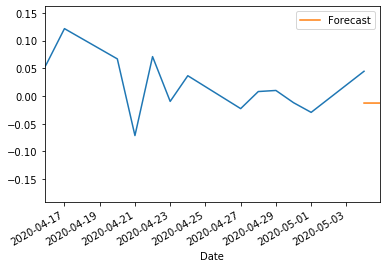

In [77]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [78]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')